In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import rpy2.robjects as robjects
from sklearn.preprocessing import MinMaxScaler
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
import skdim
import os.path
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc, precision_recall_curve, average_precision_score, PrecisionRecallDisplay
import umap.umap_ as umap
from tqdm import tqdm
import json
import numpy as np
import math
from scipy.stats import mannwhitneyu
from json import JSONEncoder
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from rpy2.robjects import pandas2ri
from sklearn.manifold import TSNE

pandas2ri.activate()

/home/ale/.local/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version. The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


# Import data

In [2]:
# import data from csv 
cnv = pd.read_csv('dataset_hg19/dataset/cnv.csv', sep=' ')

In [3]:
mirna = pd.read_csv('dataset_hg19/dataset/mirna.csv', sep=' ')

In [4]:
mrna = pd.read_csv('dataset_hg19/dataset/mrna.csv', sep=' ')

In [5]:
proteins = pd.read_csv('dataset_hg19/dataset/proteins.csv', sep=' ')
len(proteins.columns)

216

# Import label

In [6]:
label = pd.read_csv('dataset_hg19/dataset/labels_pfi.csv', sep=' ')

# Normalize data

In [7]:
def dataNormalization(scaler, data):
    scl = scaler()
    model = scl.fit(data)
    scaled_data = model.transform(data)
    
    return pd.DataFrame(scaled_data, columns=data.columns, index=data.index)

# Filter feature with low variability

In [8]:
def filter_features_with_low_variability(data, alfa) -> pd.DataFrame:
    #Delete columns with standard deviation < alfa (0.10?)
    for column in data:
        if data[column].std() < alfa:
            #print(f'column: {column} has standard deviation < {alfa}, removed')
            data.drop(column, axis=1, inplace=True)
            
    return data

# Normalize and filter datasets

In [9]:
dataset_dict = {'cnv': cnv, 'mirna': mirna, 'mrna': mrna, 'proteins': proteins}

In [10]:
def create_data_normalized_filtered(data_dict, scaler, min_variance):
    dict_filtered_nornalize = {}
    for (key, value) in zip(data_dict, data_dict.values()):
        if key != 'cnv':
            dict_filtered_nornalize[key] = filter_features_with_low_variability(dataNormalization(MinMaxScaler, value), 0.05)
        else:
            dict_filtered_nornalize[key] = value
    return dict_filtered_nornalize

# Store and retrieve data normalize and filtered

In [11]:
def mkdir_p(path):
    try:
        os.makedirs(path)
    except OSError as exc: # Python >2.5
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else: raise

In [12]:
def store_filtered_normalize_data(dataset_dict):
    mkdir_p('filtered_normalize_data')
    filtered_normalize_data = create_data_normalized_filtered(dataset_dict, MinMaxScaler, 0.05)
    for data in dataset_dict:
        filtered_normalize_data[data].to_json('filtered_normalize_data/'+data+'.json')

In [13]:
def load_filtered_normalize_data(dataset_dict):
    dict_test = {}
    if os.path.exists('filtered_normalize_data'):
        for data in dataset_dict:
            with open('filtered_normalize_data/'+data+'.json', 'r') as fp:
                dataset = pd.read_json(fp)
                dict_test[data] = dataset
        return dict_test
    else:
        store_filtered_normalize_data(dataset_dict)
        load_filtered_normalize_data(dataset_dict)

In [14]:
dataset_dict = {'cnv': cnv, 'mirna': mirna, 'mrna': mrna, 'proteins': proteins}

datasets = load_filtered_normalize_data(dataset_dict)

In [15]:
print('DATI CARICATI CON SUCCESSO')

DATI CARICATI CON SUCCESSO


In [16]:
datasets = load_filtered_normalize_data(dataset_dict)

# Create concatenation of all dataset

In [17]:
dataset_concat = pd.concat([datasets['cnv'], datasets['proteins'], datasets['mrna'], datasets['mirna']], axis=1)

In [18]:
datasets['concat'] = dataset_concat

# Remove correlated feature using R code

In [19]:
robjects.r("""
install.packages('caret')
""")

R[write to console]: Installazione pacchetto in ‘/usr/local/lib/R/site-library’
(perché ‘lib’ non è specificato)

R[write to console]: apertura URL 'https://cloud.r-project.org/src/contrib/caret_6.0-93.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 2273775 bytes (2.2 MB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to con

gcc -I"/usr/share/R/include" -DNDEBUG      -fpic  -g -O2 -ffile-prefix-map=/build/r-base-Faorqz/r-base-4.2.2.20221110=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c caret.c -o caret.o
gcc -shared -L/usr/lib/R/lib -Wl,-Bsymbolic-functions -flto=auto -ffat-lto-objects -flto=auto -Wl,-z,relro -o caret.so caret.o -L/usr/lib/R/lib -lR


** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (caret)
R[write to console]: 

R[write to console]: 
R[write to console]: I pacchetti scaricati con il codice sorgente sono in
	‘/tmp/Rtmpir3l9x/downloaded_packages’
R[write to console]: 
R[write to console]: 



<rpy2.rinterface.NULLType object at 0x7f65cfa93a40> [RTYPES.NILSXP]

In [20]:
robjects.r("""
library(doParallel)
""")

R[write to console]: Caricamento del pacchetto richiesto: foreach

R[write to console]: Caricamento del pacchetto richiesto: iterators

R[write to console]: Caricamento del pacchetto richiesto: parallel



array(['doParallel', 'parallel', 'iterators', 'foreach', 'tools', 'stats',
       'graphics', 'grDevices', 'utils', 'datasets', 'methods', 'base'],
      dtype='<U10')

In [21]:
robjects.r("""
remove_correlated_par <- function(df, dim_split = 1000, maxiter = 5, method = "pearson", cutoff = 0.8){
  
  #df has features on columns
  X = t(df)
  niter = 0
  if (!is.finite(dim_split)) dim_split = nrow(X)
  cat("dim(X) before starting remove correlation: ", dim(X), "\n")
  while(niter < maxiter ){
    cat("niter = ", niter, '\n')
    filtered_X = NULL
    
    cl <- makeCluster(4)
    registerDoParallel(cl)
    
    filtered_X = foreach(nR = seq(1, nrow(X), by=dim_split), 
                         .combine='rbind', .packages = c("caret")) %dopar% {
                           
         subX = X[nR:min(nrow(X), (nR+dim_split-1)), ]
         cc = cor(t(subX), use = "pairwise.complete.obs", method = "kendall")
         
         select_corr = caret::findCorrelation(cc, cutoff = cutoff, exact = FALSE)
         #print(length(select_corr))
         
         if (length(select_corr)>0){ 
           subX = subX[-select_corr, ]
         }
         
         return(subX)
           
     }
    
    stopCluster(cl)
    
    print(names(filtered_X))
    #    if (length(unique(filtered_X[,1]))>1) cat('PROBLEMA!')
    no_removed = nrow(X)-nrow(filtered_X)
    cat('Removed = ', no_removed, '\n')
    cat('dim filetered_X =', dim(filtered_X), '\n')

    X = filtered_X[sample(nrow(filtered_X)), ]
    
    niter = niter + 1
    cat("nrow(X) =", dim(X), '\n')
    if (no_removed ==0) break;
  }
  cat('final dimension = ', dim(t(X)), '\n')
  
  
  return(t(X))
    }
    """)

R object with classes: ('function',) mapped to:

In [22]:
with localconverter(robjects.default_converter + pandas2ri.converter):
    r_proteins = robjects.conversion.py2rpy(datasets['proteins'])

In [23]:
with localconverter(robjects.default_converter + pandas2ri.converter):
    r_miRNA = robjects.conversion.py2rpy(datasets['mirna'])

In [24]:
with localconverter(robjects.default_converter + pandas2ri.converter):
    r_mRNA = robjects.conversion.py2rpy(datasets['mrna'])

In [25]:
with localconverter(robjects.default_converter + pandas2ri.converter):
    r_cnv = robjects.conversion.py2rpy(datasets['cnv'])

In [26]:
with localconverter(robjects.default_converter + pandas2ri.converter):
    r_concat = robjects.conversion.py2rpy(datasets['concat'])

# Store data in local

In [27]:
def compute_and_save_result(data, path):
    data_removed = robjects.globalenv["remove_correlated_par"](data)
    df = pd.DataFrame(data=np.array(data_removed), columns=data_removed.colnames)
    df.to_json(path)
    
def restore_result(file_name):
    return pd.read_json(f'elaborated_data_with_r_function/{file_name}.json')

def load_or_store_removed_correlated(data, file_name):
    if os.path.exists(f'elaborated_data_with_r_function/{file_name}.json'):
        return restore_result(file_name)
    else:
        compute_and_save_result(data, f'elaborated_data_with_r_function/{file_name}.json')
        return restore_result(file_name)

In [28]:
df_proteins_removed = load_or_store_removed_correlated(r_proteins, 'r_proteins_removed')

In [29]:
df_proteins_removed

,Rb_pS807_S811,NF2,Cyclin_E2,PRDX1,MSH2,DJ-1,PRAS40_pT246,c-Kit,GAPDH,mTOR_pS2448,...,p21,Rad51,PR,CD31,JNK2,S6_pS235_S236,AR,PKC-alpha,Rad50,EGFR
0,0.556876,0.492744,0.584125,0.391717,0.395430,0.185574,0.617066,0.225889,0.628187,0.532247,...,0.470348,0.498258,0.256991,0.812005,0.360221,0.349707,0.455007,0.169500,0.222798,0.028842
1,0.712495,0.641532,0.307548,0.360341,0.151948,0.387452,0.495525,0.343444,0.707754,0.540128,...,0.333831,0.467601,0.277583,0.799877,0.599207,0.369679,0.599234,0.500436,0.563220,0.129827
2,0.446756,0.707661,0.626639,0.313282,0.346299,0.306858,0.477525,0.268753,0.780045,0.570756,...,0.473715,0.155313,0.275116,0.728111,0.649406,0.605604,0.624161,0.469991,0.655944,0.042311
3,0.473533,0.692861,0.469722,0.551637,0.413502,0.390525,0.619577,0.214726,0.902798,0.618668,...,0.512936,0.194229,0.218207,0.778752,0.557013,0.611758,0.637180,0.401992,0.586450,0.069372
4,0.744194,0.664300,0.446219,0.275160,0.492197,0.275742,0.436008,0.200455,0.681855,0.619638,...,0.557623,0.327831,0.255933,0.789019,0.552120,0.836554,0.596219,0.117931,0.627511,0.098042
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
622,0.623235,0.313359,0.242463,0.567832,0.669428,0.333785,0.598971,0.205247,0.650726,0.556632,...,1.000000,0.493370,0.284322,0.778521,0.277425,0.628068,0.484787,0.394448,0.457143,0.075798
623,0.735589,0.591318,0.308186,0.488325,0.463139,0.320192,0.358247,0.199404,0.739182,0.636403,...,0.357564,0.438043,0.225250,0.636077,0.507957,0.548177,0.575999,0.209467,0.808045,0.070274
624,0.759447,0.675566,0.438230,0.516766,0.517702,0.420811,0.425565,0.192443,0.817319,0.616971,...,0.346363,0.257651,0.257439,0.750852,0.750632,0.351290,0.470429,0.374299,0.584667,0.063464
625,0.575545,0.652387,0.307742,0.320834,0.318256,0.423565,0.453955,0.255237,0.704176,0.591668,...,0.391596,0.427625,0.241871,0.764212,0.776912,0.438820,0.737364,0.263880,0.683068,0.069122


In [30]:
df_mirna_removed = load_or_store_removed_correlated(r_miRNA, 'r_mirna_removed')

In [31]:
df_mirna_removed

,hsa-mir-1468,hsa-let-7g,hsa-mir-629,hsa-let-7i,hsa-mir-650,hsa-mir-101-2,hsa-mir-564,hsa-mir-151,hsa-mir-1252,hsa-mir-200b,...,hsa-mir-617,hsa-mir-3183,hsa-mir-219-1,hsa-mir-186,hsa-mir-639,hsa-mir-181d,hsa-mir-3180-1,hsa-mir-3192,hsa-mir-615,hsa-mir-559
0,0.002257,0.124417,0.127997,0.128456,0.0,0.074906,0.0,0.112124,0.000000,0.051008,...,0,0.285714,0.065217,0.065086,0.000000,0.029491,0,0.2,0.064157,0.000000
1,0.019187,0.125276,0.138631,0.181951,0.0,0.198502,0.0,0.083745,0.000000,0.146458,...,0,0.000000,0.130435,0.070078,0.024390,0.036640,0,0.0,0.011121,0.000000
2,0.023702,0.113670,0.057425,0.140892,0.0,0.212547,0.0,0.099683,0.142857,0.072503,...,0,0.000000,0.057971,0.079293,0.073171,0.084540,0,0.0,0.017109,0.000000
3,0.028217,0.227094,0.219451,0.231555,0.0,0.257959,0.0,0.132620,0.142857,0.130909,...,0,0.142857,0.123188,0.153691,0.048780,0.018409,0,0.0,0.041061,0.076923
4,0.014673,0.158868,0.194122,0.104141,0.0,0.092228,0.0,0.102098,0.000000,0.132872,...,0,0.285714,0.108696,0.046463,0.000000,0.029312,0,0.2,0.046193,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
622,0.049661,0.201486,0.053558,0.150757,0.0,0.195693,0.0,0.094572,0.000000,0.070566,...,0,0.000000,0.036232,0.074206,0.000000,0.021269,0,0.0,0.012831,0.000000
623,0.044018,0.194363,0.085460,0.146450,0.0,0.244850,0.0,0.112383,0.000000,0.031422,...,0,0.000000,0.101449,0.091005,0.097561,0.029491,0,0.0,0.054748,0.000000
624,0.072235,0.517686,0.196442,0.337224,0.0,0.705993,0.0,0.257246,0.000000,0.149713,...,0,0.142857,0.181159,0.231737,0.121951,0.050402,0,0.0,0.017109,0.000000
625,0.034989,0.177966,0.069606,0.372794,0.0,0.424157,0.0,0.086553,0.000000,0.071615,...,0,0.000000,0.115942,0.100989,0.024390,0.031457,0,0.2,0.020530,0.000000


In [32]:
df_mrna_removed = load_or_store_removed_correlated(r_mRNA, 'r_mrna_removed')

In [33]:
df_mrna_removed

,SIGLEC1,TULP4,EIF2C4,RPS6KA1,ANKRD29,FBXO22,ATXN7L2,RBM4B,DPPA4,RPS17,...,FAM184B,C10orf107,PCDHGA4,DOM3Z,POP5,TRIO,EXT1,KIAA1199,SLC2A4,ARMCX5
0,0.059148,0.098960,0.084178,0.029322,0.006367,0.067629,0.072150,0.106883,0.021978,0.043359,...,0.010578,0.006486,0.002561,0.204134,0.186788,0.061893,0.039499,0.037976,0.016722,0.021216
1,0.048872,0.144359,0.115872,0.121590,0.024558,0.110473,0.183261,0.174465,0.032967,0.197186,...,0.007135,0.009730,0.014925,0.377301,0.179954,0.069344,0.079451,0.060677,0.021182,0.274224
2,0.081704,0.107946,0.151876,0.079088,0.007926,0.040446,0.102453,0.108131,0.000000,0.206332,...,0.008439,0.067027,0.020400,0.250538,0.095900,0.086627,0.121011,0.074785,0.025641,0.152312
3,0.069173,0.043637,0.036258,0.074676,0.007926,0.042240,0.065416,0.039717,0.032967,0.081390,...,0.011760,0.091892,0.003244,0.186423,0.047380,0.021435,0.004322,0.035006,0.012263,0.093730
4,0.052632,0.066776,0.037525,0.097541,0.002599,0.118404,0.057720,0.070909,0.000000,0.090940,...,0.012161,0.000000,0.001366,0.247633,0.156264,0.002954,0.048344,0.014798,0.060201,0.188410
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
622,0.004010,0.085041,0.145538,0.077043,0.043919,0.071946,0.167388,0.200457,0.000000,0.215906,...,0.008611,0.030270,0.013510,0.549950,0.088838,0.048959,0.057591,0.009759,0.051282,0.153578
623,0.131746,0.072767,0.016481,0.025663,0.007796,0.000000,0.175084,0.045124,0.032967,0.193866,...,0.000000,0.003243,0.000000,0.139981,0.290661,0.000000,0.001709,0.001061,0.012263,0.050032
624,0.166667,0.147942,0.271298,0.137784,0.032614,0.112289,0.113035,0.106467,0.131868,0.218406,...,0.069634,0.046486,0.021042,0.389458,0.114351,0.139673,0.085833,0.022966,0.441472,0.216909
625,0.042941,0.050802,0.039554,0.152580,0.012734,0.045110,0.092833,0.100853,0.032967,0.344193,...,0.004108,0.017297,0.000854,0.336216,0.230524,0.009552,0.036534,0.005993,0.063545,0.120963


In [34]:
df_cnv_removed = load_or_store_removed_correlated(r_cnv, 'r_cnv_removed')

In [35]:
df_cnv_removed

,NUTM2D,NRG1,IGSF5,snoU13|ENSG00000238702.1,FGFR3,CD59,OTX2,BAI2,C14orf182,ACTN3,...,ABCA6,GALNT18,OR1M1,YAF2,ZAR1,COBLL1,OPRK1,CLNS1A,RFX4,FAM111A
0,-1,1,-1,1,-1,0,1,-1,1,0,...,-1,0,-1,0,-1,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
2,0,-1,0,0,0,0,0,0,0,0,...,1,0,1,0,0,-1,0,0,0,0
3,0,0,-1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,0,1,0,-1,0,-1,...,1,1,-1,0,0,0,1,2,0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
622,0,1,1,1,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
623,0,-1,0,-1,-1,0,-1,-1,-1,0,...,0,0,1,0,0,0,0,1,0,0
624,0,-1,0,0,0,0,-1,0,-1,0,...,0,0,0,0,0,0,1,2,0,-1
625,0,0,0,1,1,-1,0,-1,0,-1,...,0,-1,0,1,1,0,0,-1,1,-1


In [36]:
df_concat_removed = load_or_store_removed_correlated(r_concat, 'r_concat_removed')

In [37]:
df_concat_removed

,ADD2,C1orf126,PDIA6,TADA2B,hsa-mir-877,SNORA37,GABRB2,MTMR9L,C1orf58,CDCA4,...,LOC283761,CEP110,ZNF429,hsa-mir-596,PSD2,ACOX3,ACPT,THADA,PLXDC1,PYHIN1
0,0.048185,0.015150,0.039343,0.112845,0.164706,0.0,0.008668,0.147788,0.049137,0.093005,...,0.0,0.160219,0.082694,0.0,0.020792,0.002061,0.000000,0.136327,0.202797,0.045530
1,0.010533,0.011674,0.067999,0.290476,0.035294,0.0,0.122931,0.128319,0.067488,0.209378,...,0.0,0.161907,0.106991,0.0,0.012871,0.135113,0.078125,0.158953,0.116393,0.014487
2,0.004258,0.018701,0.037030,0.229185,0.035294,0.0,0.104807,0.232743,0.062209,0.128992,...,0.0,0.205092,0.261722,0.0,0.007921,0.151809,0.015625,0.085933,0.202760,0.013245
3,0.012102,0.006392,0.016736,0.122457,0.047059,0.0,0.021277,0.176106,0.021540,0.007322,...,0.0,0.089042,0.044757,0.0,0.007921,0.087190,0.000000,0.061593,0.122070,0.045116
4,0.000448,0.009238,0.073257,0.160779,0.047059,0.0,0.003940,0.195575,0.062235,0.047359,...,0.0,0.109298,0.065644,0.0,0.000000,0.120169,0.000000,0.109587,0.036496,0.000414
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
622,0.008516,0.054363,0.031161,0.217701,0.047059,0.0,0.038613,0.679646,0.051220,0.038791,...,0.0,0.133493,0.089088,0.0,0.035644,0.235803,0.078125,0.137241,0.087567,0.003725
623,0.004706,0.016362,0.016306,0.075396,0.070588,0.0,0.003940,0.155752,0.003078,0.008880,...,0.0,0.033057,0.034101,0.0,0.000000,0.104607,0.015625,0.148669,0.043849,0.043874
624,0.042358,0.022130,0.041858,0.270503,0.082353,0.0,0.046493,0.361062,0.097805,0.039726,...,0.0,0.273597,0.068627,0.0,0.024752,0.100897,0.000000,0.172209,0.229248,0.118791
625,0.011654,0.024507,0.033712,0.187243,0.035294,0.0,0.010244,0.562832,0.005250,0.051721,...,0.0,0.051343,0.068627,0.0,0.027723,0.151912,0.015625,0.184550,0.090343,0.016970


In [38]:
print('DATI MANIPOLATI CON LA FUNZIONE R ELIMINANDO LE FEATURE CORRELATE')

DATI MANIPOLATI CON LA FUNZIONE R ELIMINANDO LE FEATURE CORRELATE


# Intrinsic dimension estimation using the TwoNN algorithm

In [39]:
def execute_instrinsic_dimension_estimation(data):
    twoNN = skdim.id.TwoNN().fit(data)
    #estimate local intrinsic dimension (dimension in k-nearest-neighborhoods around each point):
    lpca = skdim.id.TwoNN().fit_pw(data,
                                  n_neighbors = 100,
                                  n_jobs = 1)

    #get estimated intrinsic dimension
    return twoNN.dimension_, np.mean(lpca.dimension_pw_)

In [40]:
intr_dimension_proteins, _ = execute_instrinsic_dimension_estimation(df_proteins_removed)

In [41]:
intr_dimension_mirna, _ = execute_instrinsic_dimension_estimation(df_mirna_removed)

In [42]:
intr_dimension_mrna, _ = execute_instrinsic_dimension_estimation(df_mrna_removed)

In [43]:
intr_dimension_cnv, _ = execute_instrinsic_dimension_estimation(df_cnv_removed)

In [44]:
intr_dimension_concat, _ = execute_instrinsic_dimension_estimation(df_concat_removed)

In [45]:
print('CALCOLATE LE DIMENSIONI INTRINSECHE')

CALCOLATE LE DIMENSIONI INTRINSECHE


# Feature extraction using umap

In [46]:
def execute_umap(n_components, X, y):
    return umap.UMAP(n_neighbors=5, n_components=n_components, random_state=42).fit_transform(X, y)

In [47]:
r_proteins_umap = execute_umap(math.trunc(intr_dimension_proteins), df_proteins_removed, label)

In [48]:
r_miRNA_umap = execute_umap(math.trunc(intr_dimension_mirna), df_mirna_removed, label)

In [49]:
r_mRNA_umap = execute_umap(math.trunc(intr_dimension_mrna), df_mrna_removed, label)

In [50]:
r_cnv_umap = execute_umap(math.trunc(intr_dimension_cnv), df_cnv_removed, label)

In [51]:
r_concat_umap = execute_umap(math.trunc(intr_dimension_concat), df_concat_removed, label)

In [52]:
print('ESTRATTE LE FEATURE USANDO UMAP')

ESTRATTE LE FEATURE USANDO UMAP


# Train using intrinsic dimensionality and umap calculated externally

In [53]:
def train_using_intrinsic_dimensionality_and_umap(X, label, num_external_fold,
                                          type_dataset, tecnique_feature_selection,
                                          path):
    
    """
    X : data using number of features of intrinsic dimensionality and appliying umap features extraction.
    """
    
    aucs = []
    y_score_concatenated = []
    y_test_fold_concatenated = []
    result_dict = {}
    result_dict[type_dataset] = {}
    result_dict[type_dataset][tecnique_feature_selection] = {}   
    
    label_numpy = label['x'].to_numpy()
    
    external_fold = StratifiedKFold(n_splits=num_external_fold, shuffle=True, random_state=1)
    
    for train_index, test_index in tqdm(external_fold.split(X, label_numpy), desc=f"Running fold ", dynamic_ncols=True, leave=False):
        
        X_train_fold, X_test_fold = X[train_index], X[test_index]
        y_train_fold, y_test_fold = label_numpy[train_index], label_numpy[test_index]
        
        clf = GridSearchCV(estimator=RandomForestClassifier(),
                   scoring='average_precision',
                   param_grid=model_selection_grid_DT, 
                   cv=2, 
                   n_jobs=-1)
        clf.fit(X_train_fold, y_train_fold)
        
        # Get the predicited probability of testing data
        y_score = clf.predict_proba(X_test_fold)[:, 1]
        
        #calculate precision and recall
        precision, recall, thresholds = precision_recall_curve(y_test_fold, y_score)

        #plot_precision_recall_curve(classifier, X_test_selected_feature, y_test_fold)
        
        y_score_concatenated = np.concatenate((y_score_concatenated, y_score), axis=None)
        y_test_fold_concatenated = np.concatenate((y_test_fold_concatenated, y_test_fold), axis=None)
        
        
        # Use AUC function to calculate the area under the curve of precision recall curve
        auc_precision_recall = auc(recall, precision)
        
        aucs.append(auc_precision_recall)
        #print('auc: {:.3f} using params {}:'.format(auc_precision_recall, clf.best_params_))
    
    internal_auc = np.mean(aucs)
    
    #calculate precision and recall
    precision, recall, thresholds = precision_recall_curve(y_test_fold_concatenated, y_score_concatenated)
    
    external_auc = auc(recall, precision)
    #plot precision recall curve
    PrecisionRecallDisplay.from_predictions(y_test_fold_concatenated, y_score_concatenated)
    #plt.show()
    
    result_dict[type_dataset][tecnique_feature_selection]['internal'] = '{0:.4f}'.format(internal_auc)
    result_dict[type_dataset][tecnique_feature_selection]['external'] = '{0:.4f}'.format(external_auc)
    result_dict[type_dataset][tecnique_feature_selection]['best_estimator'] = str(clf.best_estimator_)
    
    plt.savefig(path+tecnique_feature_selection+'/'+type_dataset+'_'+'AUC_External.pdf')
    
    with open(path+tecnique_feature_selection+'/'+type_dataset+'.json', 'w', encoding='utf-8') as fp:
        json.dump(result_dict[type_dataset], fp, ensure_ascii=False, indent=4)
    
    return '{0:.4f}'.format(internal_auc), '{0:.4f}'.format(external_auc), clf.best_estimator_

In [54]:
model_selection_grid_DT = [
    {'criterion': ['gini', 'entropy'],
     'max_leaf_nodes': [None, 2, 5, 10],
     'max_features': [None, 'sqrt', 'log2'],
    'n_estimators': [51, 101, 251, 500]}
]

# Train proteins

('0.7082',
 '0.6971',
 RandomForestClassifier(criterion='entropy', max_features='log2',
                        max_leaf_nodes=5, n_estimators=500))

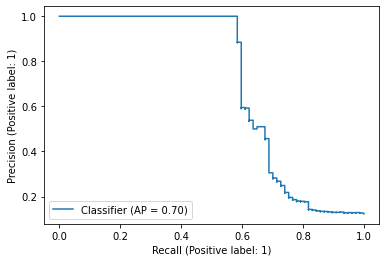

In [56]:
!mkdir 'result_new_experiment_externally/r_function_intrinsic_with_umap'
train_using_intrinsic_dimensionality_and_umap(r_proteins_umap, label, 10, 'proteins', 'r_function_intrinsic_with_umap', 'result_new_experiment_externally/')

In [ ]:
print('FINITO ADDESTRAMENTO PROTEINS')

# Train miRNA

FINITO ADDESTRAMENTO MIRNA


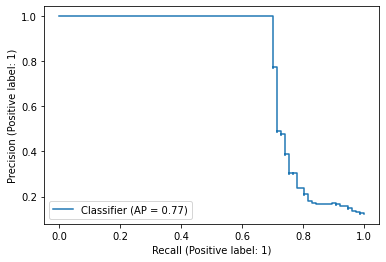

In [57]:
train_using_intrinsic_dimensionality_and_umap(r_miRNA_umap, label, 10, 'mirna', 'r_function_intrinsic_with_umap', 'result_new_experiment_externally/')

print('FINITO ADDESTRAMENTO MIRNA')

# Train mRNA

FINITO ADDESTRAMENTO MRNA


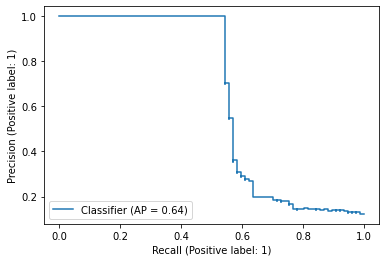

In [58]:
train_using_intrinsic_dimensionality_and_umap(r_mRNA_umap, label, 10, 'mrna', 'r_function_intrinsic_with_umap', 'result_new_experiment_externally/')

print('FINITO ADDESTRAMENTO MRNA')

# Train cnv

FINITO ADDESTRAMENTO CNV


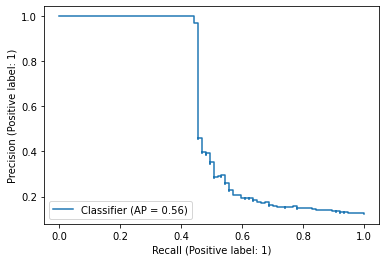

In [59]:
train_using_intrinsic_dimensionality_and_umap(r_cnv_umap, label, 10, 'cnv', 'r_function_intrinsic_with_umap', 'result_new_experiment_externally/')

print('FINITO ADDESTRAMENTO CNV')

# Train concat

FINITO ADDESTRAMENTO CONCAT


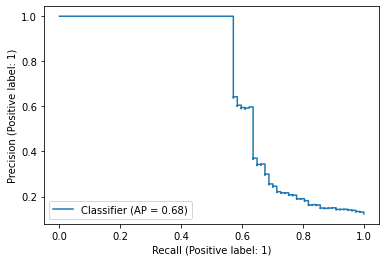

In [60]:
train_using_intrinsic_dimensionality_and_umap(r_concat_umap, label, 10, 'concat', 'r_function_intrinsic_with_umap', 'result_new_experiment_externally/')

print('FINITO ADDESTRAMENTO CONCAT')

# Train using intrinsic dimensionality and umap calculated internally

In [62]:
def train_using_intrinsic_dimensionality_and_umap_internally(X, label, num_external_fold,
                                          type_dataset, tecnique_feature_selection,
                                          path):
    
    """
    X : data using number of features of intrinsic dimensionality and appliying umap features extraction.
    """
    
    aucs = []
    y_score_concatenated = []
    y_test_fold_concatenated = []
    result_dict = {}
    result_dict[type_dataset] = {}
    result_dict[type_dataset][tecnique_feature_selection] = {}
    X_numpy = X.to_numpy()
    
    label_numpy = label['x'].to_numpy()
    
    external_fold = StratifiedKFold(n_splits=num_external_fold, shuffle=True, random_state=1)
    
    for train_index, test_index in tqdm(external_fold.split(X_numpy, label_numpy), desc=f"Running fold ", dynamic_ncols=True, leave=False):
        
        X_train_fold, X_test_fold = X_numpy[train_index], X_numpy[test_index]
        y_train_fold, y_test_fold = label_numpy[train_index], label_numpy[test_index]
        
        X_train_intr_dimension_proteins, _ = execute_instrinsic_dimension_estimation(X_train_fold)

        X_train_r_proteins_umap = execute_umap(math.trunc(X_train_intr_dimension_proteins), X_train_fold, y_train_fold)
        X_test_r_proteins_umap = execute_umap(math.trunc(X_train_intr_dimension_proteins), X_test_fold, y_test_fold)
        
        clf = GridSearchCV(estimator=RandomForestClassifier(),
                   scoring='average_precision',
                   param_grid=model_selection_grid_DT, 
                   cv=2, 
                   n_jobs=-1)
        clf.fit(X_train_r_proteins_umap, y_train_fold)
        
        # Get the predicited probability of testing data
        y_score = clf.predict_proba(X_test_r_proteins_umap)[:, 1]
        
        #calculate precision and recall
        precision, recall, thresholds = precision_recall_curve(y_test_fold, y_score)

        #plot_precision_recall_curve(classifier, X_test_selected_feature, y_test_fold)
        
        y_score_concatenated = np.concatenate((y_score_concatenated, y_score), axis=None)
        y_test_fold_concatenated = np.concatenate((y_test_fold_concatenated, y_test_fold), axis=None)
        
        
        # Use AUC function to calculate the area under the curve of precision recall curve
        auc_precision_recall = auc(recall, precision)
        
        aucs.append(auc_precision_recall)
        #print('auc: {:.3f} using params {}:'.format(auc_precision_recall, clf.best_params_))
    
    internal_auc = np.mean(aucs)
    
    #calculate precision and recall
    precision, recall, thresholds = precision_recall_curve(y_test_fold_concatenated, y_score_concatenated)
    
    external_auc = auc(recall, precision)
    #plot precision recall curve
    PrecisionRecallDisplay.from_predictions(y_test_fold_concatenated, y_score_concatenated)
    #plt.show()
    
    result_dict[type_dataset][tecnique_feature_selection]['internal'] = '{0:.4f}'.format(internal_auc)
    result_dict[type_dataset][tecnique_feature_selection]['external'] = '{0:.4f}'.format(external_auc)
    result_dict[type_dataset][tecnique_feature_selection]['best_estimator'] = str(clf.best_estimator_)
    
    plt.savefig(path+tecnique_feature_selection+'/'+type_dataset+'_'+'AUC_External.pdf')
    
    with open(path+tecnique_feature_selection+'/'+type_dataset+'.json', 'w', encoding='utf-8') as fp:
        json.dump(result_dict[type_dataset], fp, ensure_ascii=False, indent=4)
    
    return '{0:.4f}'.format(internal_auc), '{0:.4f}'.format(external_auc), clf.best_estimator_

('0.3700',
 '0.1867',
 RandomForestClassifier(criterion='entropy', max_features='log2',
                        max_leaf_nodes=5, n_estimators=101))

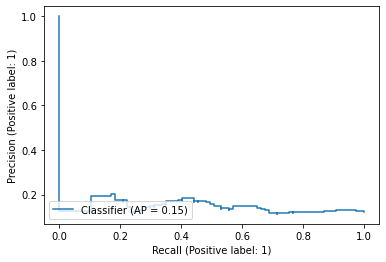

In [63]:
!mkdir 'result_new_experiment_internally/r_function_intrinsic_with_umap'
train_using_intrinsic_dimensionality_and_umap_internally(df_proteins_removed, label, 10, 'proteins', 'r_function_intrinsic_with_umap', 'result_new_experiment_internally/')

('0.2766',
 '0.1517',
 RandomForestClassifier(max_features='log2', max_leaf_nodes=5, n_estimators=51))

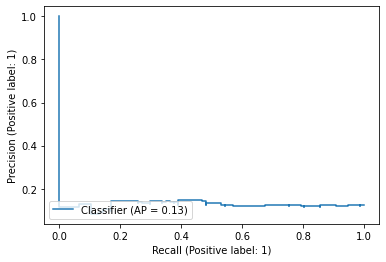

In [64]:
train_using_intrinsic_dimensionality_and_umap_internally(df_mirna_removed, label, 10, 'mirna', 'r_function_intrinsic_with_umap', 'result_new_experiment_internally/')

('0.4645', '0.2083', RandomForestClassifier(n_estimators=500))

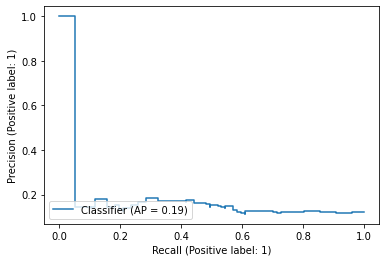

In [65]:
train_using_intrinsic_dimensionality_and_umap_internally(df_mrna_removed, label, 10, 'mrna', 'r_function_intrinsic_with_umap', 'result_new_experiment_internally/')

('0.1818',
 '0.1548',
 RandomForestClassifier(criterion='entropy', max_features='log2',
                        max_leaf_nodes=2, n_estimators=251))

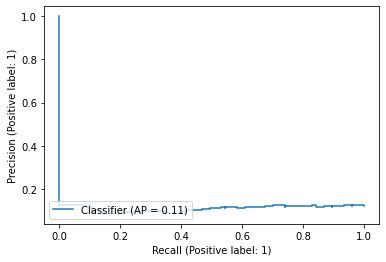

In [66]:
train_using_intrinsic_dimensionality_and_umap_internally(df_cnv_removed, label, 10, 'cnv', 'r_function_intrinsic_with_umap', 'result_new_experiment_internally/')

('0.2519',
 '0.1455',
 RandomForestClassifier(max_features='log2', max_leaf_nodes=10, n_estimators=51))

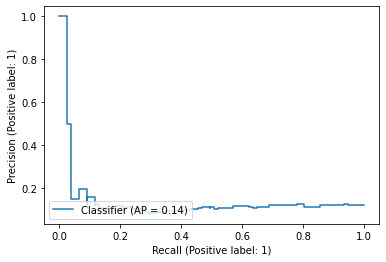

In [67]:
train_using_intrinsic_dimensionality_and_umap_internally(df_concat_removed, label, 10, 'concat', 'r_function_intrinsic_with_umap', 'result_new_experiment_internally/')